In [121]:
# vampW code

from scipy.stats import norm
import numpy as np
import sympy
import scipy

# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior: # checked!
    la = 0.5
    sigma = 1
    
    def __init__(self, la, sigma):
        self.la = la
        self.sigma = sigma
    
def den_beta(r,gam1,prior): # checked!
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(sigma + 1.0/gam1))
    ratio = gam1 * r / (gam1 + 1/sigma) * B / (A + B)
    return ratio

def der_den_beta(r,gam1,prior): # checked!
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(sigma + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (sigma + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/sigma))
    ratio = gam1 / (gam1 + 1/sigma) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/sigma)
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = [0], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    z = den_z(p1, tau1, y, alpha, mu)
    nom = alpha * alpha * np.power(y, alpha-1) * np.exp(- alpha * (mu + z) - emc)
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    Xbeta_true = X @ beta_true
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        
        # Denoising x
        print("->DENOISING")
        vect_den_beta = lambda x: den_beta(x, gam1, prior)
        x1_hat = vect_den_beta(r1)
        #print("shape of x1_hat = ", x1_hat.shape )
        #print("shape of beta_true = ", beta_true.shape )
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # reporting quality of estimation
            print("corr(x1_hat, beta_true) = ", np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true))
            print("l2 error for x1_hat = ", np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true))
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        print("alpha1 = ", alpha1)
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        print("gam2 = ", gam2)
        
        # Denoising z
        z1_hat = den_z(p1, tau1, y, alpha, mu) 
        # reporting quality of estimation
        print("corr(z1_hat, X*beta_true) = ", np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z1_hat = ", np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        beta1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("beta1 = ", beta1)
        p2 = (z1_hat - beta1 * p1) / (1-beta1)
        tau2 = tau1 * (1-beta1) / beta1
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        x2_hat = np.matmul( vh.transpose() , (tau2 * (u * s).transpose() @ p2 + gam2 * vh @ r2) )
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m;
        print("alpha2 = ", alpha2)
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        beta2 = (1-alpha2) * m / n;
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        tau1 = tau2 * (1-beta2) / beta2
        print("tau1 = ", tau1)
        print("\n")
    return x1_hat, gam1
    
    
    
    


In [122]:
from numpy import random
import numpy as np
import sympy

emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m])
    return X

def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def sim_pheno(X, beta, mu, h2):
    # logY_i = mu + xi beta + c(wi - Ewi), wi = - standard Gumbel distribution
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    wi = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp( mu + g + c * (wi + emc) )
    return y

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y = sim_pheno(X, beta, mu, h2)
    return X,beta,y
    
    

In [123]:
# running simulation

n=300
m=300
p=0.4
la=0.1
sigma=1
h2=0.5
    
X,beta,y = sim_model(n,m,p,la,sigma,h2)

print("Var(y) = ", np.var(y))
r1 = np.zeros((m,1))
p1 = np.zeros((n,1))
tau1 = 1e-2
gam1 = 1.0 / (la * sigma)
print("gam1 = ", gam1)
pr = prior(la = la, sigma = sigma)
alpha = 1
mu = 0

maxiter = 4

est, gam1 = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)
#print(est)


Var(y) =  90319669.00035936
gam1 =  10.0
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.03241531]
gam1 / (gam1 + 1/sigma) =  0.9090909090909091
alpha1 =  0.029468460789784066
gam2 =  329.34585424518457
corr(z1_hat, X*beta_true) =  [[0.51109784]]
l2 error for z1_hat =  0.8953143728319459
beta1 =  13.022849332027544
tau2 = -0.009232118890033792
->LMMSE
corr(x2_hat, beta_true) =  [[0.07075498]]
alpha2 =  0.995421040564689
gam1 =  1.5149984231004692
corr(z2_hat, beta_true) =  [[-0.17590723]]
tau1 =  -2.0069724403466562


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [26.72749052]
corr(x1_hat, beta_true) =  [[nan]]
l2 error for x1_hat =  nan
B / (A+B) =  [1.]
gam1 / (gam1 + 1/sigma) =  0.6023854365812252
alpha1 =  nan
gam2 =  nan
corr(z1_hat, X*beta_true) =  [[-0.53497078]]
l2 error for z1_hat =  10.812106132029266


/tmp/ipykernel_2830337/2874743819.py:22: RuntimeWarning: invalid value encountered in divide
  ratio = gam1 * r / (gam1 + 1/sigma) * B / (A + B)
/tmp/ipykernel_2830337/2874743819.py:31: RuntimeWarning: invalid value encountered in divide
  BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
/tmp/ipykernel_2830337/2874743819.py:33: RuntimeWarning: invalid value encountered in divide
  ratio = gam1 / (gam1 + 1/sigma) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/sigma)


beta1 =  0.05578925833935735
tau2 = -33.96720072644033
->LMMSE
corr(x2_hat, beta_true) =  [[nan]]
alpha2 =  nan
gam1 =  nan
corr(z2_hat, beta_true) =  [[nan]]
tau1 =  nan


**** iteration =  2  **** 

->DENOISING
x1_hat[2] =  [nan]
corr(x1_hat, beta_true) =  [[nan]]
l2 error for x1_hat =  nan
B / (A+B) =  [nan]
gam1 / (gam1 + 1/sigma) =  nan
alpha1 =  nan
gam2 =  nan
corr(z1_hat, X*beta_true) =  [[nan]]
l2 error for z1_hat =  1.0


/tmp/ipykernel_2830337/2874743819.py:82: RuntimeWarning: invalid value encountered in divide
  print("corr(z1_hat, X*beta_true) = ", np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true))


beta1 =  nan
tau2 = nan
->LMMSE
corr(x2_hat, beta_true) =  [[nan]]
alpha2 =  nan
gam1 =  nan
corr(z2_hat, beta_true) =  [[nan]]
tau1 =  nan


**** iteration =  3  **** 

->DENOISING
x1_hat[2] =  [nan]
corr(x1_hat, beta_true) =  [[nan]]
l2 error for x1_hat =  nan
B / (A+B) =  [nan]
gam1 / (gam1 + 1/sigma) =  nan
alpha1 =  nan
gam2 =  nan
corr(z1_hat, X*beta_true) =  [[nan]]
l2 error for z1_hat =  1.0
beta1 =  nan
tau2 = nan
->LMMSE
corr(x2_hat, beta_true) =  [[nan]]
alpha2 =  nan
gam1 =  nan
corr(z2_hat, beta_true) =  [[nan]]
tau1 =  nan




In [102]:
u, s, vh = np.linalg.svd(X)
print(u.shape)
print(s.shape)
S = np.diag(s)
print(S.shape)
print(vh.shape)
print( np.mean( 2/ (2 + s * s) ) )
print(emc)

(400, 400)
(300,)
(300, 300)
(300, 300)
0.03663524338188191
0.5772156649036333


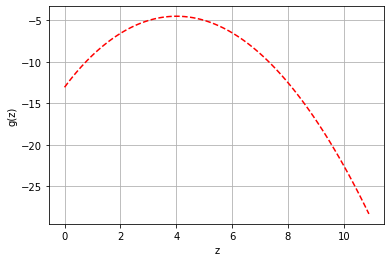

In [62]:
# plotting function g(z)

import numpy as np
import sympy
import matplotlib.pyplot as plt

emc = float( sympy.S.EulerGamma.n(10) )

tau1 = 1
p = 5
mu = 0
alpha = 1
y = 1

def g(z):
    return -alpha * z - np.power(y, alpha) * np.exp(-alpha*(z+mu) - emc) - (z-p)*(z-p)*tau1/2 

net = np.arange(0, 11.0, 0.1)

plt.figure()
plt.plot(net, g(net), 'r--')
plt.grid(True)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.savefig('gz.png')
plt.show()